<a href="https://colab.research.google.com/github/OkiHeo/python_machine_learning/blob/master/ch9_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST의 딥러닝

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#------------------------------------------------------------------

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Instructions for updating:
non-resource variables are not supported in the long term


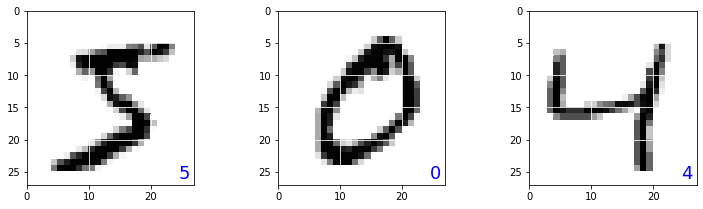

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(12, 3.2))
plt.subplots_adjust(wspace=0.5)
plt.gray()

for id in range(3):
    plt.subplot(1, 3, id+1)
    img = x_train[id, :, :]     # id번째 이미지 (28x28)를 img에 저장
    plt.pcolor(255-img)
    plt.text(24.5, 26, "%d" %y_train[id], color='blue', fontsize=18)
    plt.xlim(0, 27)
    plt.ylim(27, 0)
    plt.grid('on', color='white')
plt.show()

y_train[id] 에는 x_train[id, :, :]에 해당하는 숫자가 저장되어있다.

## 2층 피드 포워드 네트워크 모델

In [0]:
from keras.utils import np_utils


x_train = x_train.reshape(60000, 784)     # 60000x(28x28) -> 60000x784로 변환. 3차원배열을 2차원배열로 reshape
x_train = x_train.astype('float32')       # 저장된 값의 자료형을 float32형으로 변환
x_train = x_train/255                     # 0~1사이의 실수 값으로 변환한다.

num_classes = 10                          # 0~9를 표시하는 이미지라는 클래스가 존재한다.

y_train = np_utils.to_categorical(y_train, num_classes)     # y_train의 요소를 1-of-K 부호화법으로 변경한다.-> 10*10배열에서 y_train값에 해당하는 부분만 1으로 표기되어있겠다.

x_test = x_test.reshape(10000, 784)       # 10000x(28x28) -> 10000x784로 변환. 3차원배열->2차원배열
x_test = x_test.astype('float32')
x_test = x_test/255

y_test = np_utils.to_categorical(y_test, num_classes)

* 1-of-K 부호화
 
 [[0 1 0]
 
 [1 0 0]
 
 [1 0 0]
 
 [0 1 0]
 
 [1 0 0]]
 
 클래스 1, 0, 0, 1, 0에 속한다는 표기법. 자신이 속한 클래스 이외의 클래스는 0으로 표기하는 표기법.

1. 입력 : 784차원 벡터
2. 중간층 : 16개의 뉴런. by 시그모이드함수
3. 출력층 : 10개의 뉴런 by 소프트맥스함수.

In [0]:
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam


model = Sequential()      # 하나의 네트워크는 Sequential 객체이다. Sequential객체에 레이어를 하나하나 추가하는 것.
model.add(Dense(16, input_dim=784, activation='sigmoid'))     # 첫 번째 층(중간층) : 16개의 뉴런, 입력은 784차원벡터. 활성화함수는 시그모이드
model.add(Dense(10, activation='softmax'))                    # 두 번째 층(출력층) : 10개의 뉴런, 입력은 앞에서 주어졌으므로 생략. 활성화함수는 소프트맥스

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])                # 모델의 학습과정(오차함수, 최적화방법) 설정하는 함수. 오차함수를 교차 엔트로피 함수로 설정하고있다.
                                                                                                      # 최적화방법으로는 Adam() 알고리즘을 설정했다.(세련된버전의 경사하강법), 평가 기준은 metrics로 'accuracy'를 지정했다.                                        

In [22]:
import time


startTime = time.time()
history = model.fit(x_train, y_train, epochs=10, batch_size=1000, verbose=1, validation_data=(x_test, y_test))     # 학습과정을 보이도록 설정.

score = model.evaluate(x_test, y_test, verbose=0)       # 모델을 평가한다. x_test와 y_test데이터를 사용. 평가과정은 보이지 않도록 설정.

print('Test loss: ', score[0])    # model.evaluate의 첫 번째 리턴값은 loss임.
print('Test accuracy: ', score[1]) # model.evaluate의 두 번째 리턴값은 accuracy임.
print("Computation time:{0:.3f} sec.".format(time.time()-startTime))      # 모델 학습, 평가에 걸린 시간 출력.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 13us/step - loss: 2.0678 - acc: 0.2851 - val_loss: 1.7898 - val_acc: 0.4947
Epoch 2/10
60000/60000 [==============================] - 0s 8us/step - loss: 1.6086 - acc: 0.6483 - val_loss: 1.4400 - val_acc: 0.7655
Epoch 3/10
60000/60000 [==============================] - 0s 8us/step - loss: 1.3223 - acc: 0.7870 - val_loss: 1.2013 - val_acc: 0.8197
Epoch 4/10
60000/60000 [==============================] - 0s 8us/step - loss: 1.1161 - acc: 0.8240 - val_loss: 1.0221 - val_acc: 0.8441
Epoch 5/10
60000/60000 [==============================] - 0s 7us/step - loss: 0.9575 - acc: 0.8434 - val_loss: 0.8824 - val_acc: 0.8580
Epoch 6/10
60000/60000 [==============================] - 0s 7us/step - loss: 0.8336 - acc: 0.8582 - val_loss: 0.7743 - val_acc: 0.8706
Epoch 7/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.7381 - acc: 0.8689 - val_loss: 0.6904 - val_acc: 0.87

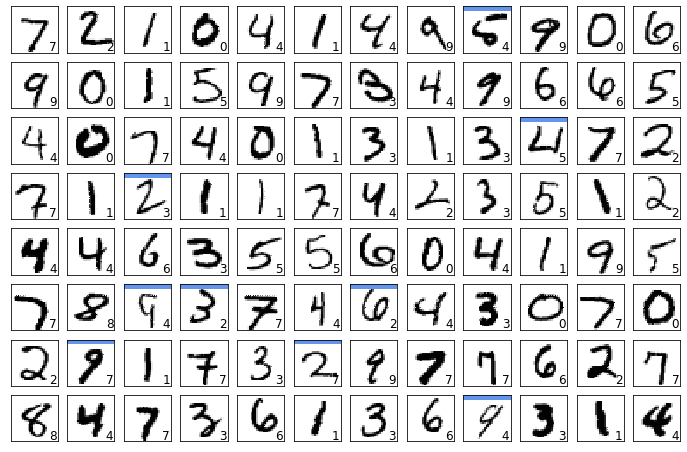

In [23]:
def show_prediction():
    n_show=96
    y=model.predict(x_test)
    plt.figure(2, figsize=(12, 8))
    plt.gray()
    
    for i in range(n_show):
        plt.subplot(8, 12, i+1)
        x = x_test[i, :]
        x = x.reshape(28, 28)
        plt.pcolor(1-x)
        wk = y[i, :]
        prediction = np.argmax(wk)
        plt.text(22, 25.5, "%d" %prediction, fontsize=12)
        if prediction != np.argmax(y_test[i, :]):
            plt.plot([0, 27], [1, 1], color='cornflowerblue', linewidth=5)
        
        plt.xlim(0, 27)
        plt.ylim(27, 0)
        plt.xticks([], "")
        plt.yticks([], "")

show_prediction()
plt.show()

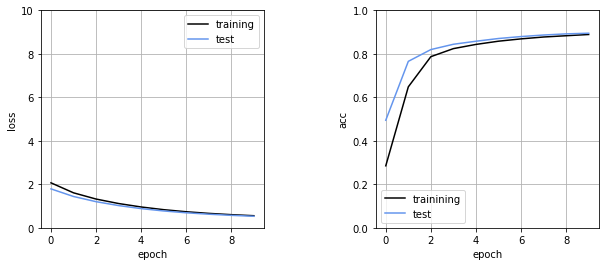

In [24]:
### 오버피팅이 일어나지 않았는지 테스트 데이터 오차의 시간 변화를 나타내보자.

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(1, figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='training', color='black')
plt.plot(history.history['val_loss'], label='test', color='cornflowerblue')
plt.ylim(0, 10)
plt.legend()
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')


plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='trainining', color='black')
plt.plot(history.history['val_acc'], label='test', color='cornflowerblue')
plt.ylim(0, 1)      # accuracy는 0~1 사이의 값
plt.legend()
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('acc')


plt.show()

정답률이 증가중... 훈련 데이터의 오차는 줄어들도록 학습시켰으니 당연히 줄어드는 것이고,


테스트 데이터의 오차도 단조감소 하고 있으므로 오버피팅이 일어나지 않았다고 할 수 있다.

In [15]:
help(model.fit)

Help on method fit in module keras.engine.training:

fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False, **kwargs) method of keras.engine.sequential.Sequential instance
    Trains the model for a fixed number of epochs (iterations on a dataset).
    
    # Arguments
        x: Input data. It could be:
            - A Numpy array (or array-like), or a list of arrays
              (in case the model has multiple inputs).
            - A dict mapping input names to the corresponding
              array/tensors, if the model has named inputs.
            - A generator or `keras.utils.Sequence` returning
              `(inputs, targets)` or `(inputs, targets, sample weights)`.
            - None (default) if feeding from framework-native


### ReLU 활성화 함수


0보다 크면 x를 그대로 출력, 0 이하는 0을 출력하는 활성화함수.<br>
긍정적인 입력의 차이를 나타내기 위해 ReLU를 사용한다.

In [0]:
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam


model = Sequential()      # 하나의 네트워크는 Sequential 객체이다. Sequential객체에 레이어를 하나하나 추가하는 것.
model.add(Dense(16, input_dim=784, activation='relu'))     # 첫 번째 층(중간층) : 16개의 뉴런, 입력은 784차원벡터. 활성화함수는 시그모이드
model.add(Dense(10, activation='softmax'))                    # 두 번째 층(출력층) : 10개의 뉴런, 입력은 앞에서 주어졌으므로 생략. 활성화함수는 소프트맥스

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])                # 모델의 학습과정(오차함수, 최적화방법) 설정하는 함수. 오차함수를 교차 엔트로피 함수로 설정하고있다.
                                                                                                      # 최적화방법으로는 Adam() 알고리즘을 설정했다.(세련된버전의 경사하강법), 평가 기준은 metrics로 'accuracy'를 지정했다.                                        

In [26]:
import time


startTime = time.time()
history = model.fit(x_train, y_train, epochs=10, batch_size=1000, verbose=1, validation_data=(x_test, y_test))     # 학습과정을 보이도록 설정.

score = model.evaluate(x_test, y_test, verbose=0)       # 모델을 평가한다. x_test와 y_test데이터를 사용. 평가과정은 보이지 않도록 설정.

print('Test loss: ', score[0])    # model.evaluate의 첫 번째 리턴값은 loss임.
print('Test accuracy: ', score[1]) # model.evaluate의 두 번째 리턴값은 accuracy임.
print("Computation time:{0:.3f} sec.".format(time.time()-startTime))      # 모델 학습, 평가에 걸린 시간 출력.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 14us/step - loss: 1.5417 - acc: 0.5443 - val_loss: 0.8968 - val_acc: 0.8072
Epoch 2/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.6663 - acc: 0.8450 - val_loss: 0.4985 - val_acc: 0.8776
Epoch 3/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.4515 - acc: 0.8827 - val_loss: 0.3901 - val_acc: 0.8999
Epoch 4/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.3756 - acc: 0.8987 - val_loss: 0.3398 - val_acc: 0.9103
Epoch 5/10
60000/60000 [==============================] - 0s 8us/step - loss: 0.3355 - acc: 0.9078 - val_loss: 0.3106 - val_acc: 0.9166
Epoch 6/10
60000/60000 [==============================] - 0s 7us/step - loss: 0.3096 - acc: 0.9132 - val_loss: 0.2920 - val_acc: 0.9199
Epoch 7/10
60000/60000 [==============================] - 0s 7us/step - loss: 0.2914 - acc: 0.9177 - val_loss: 0.2763 - val_acc: 0.92

중간층 활성화함수를 시그모이드를 사용했을 때보다 정확도가 3%p정도 상승했다.

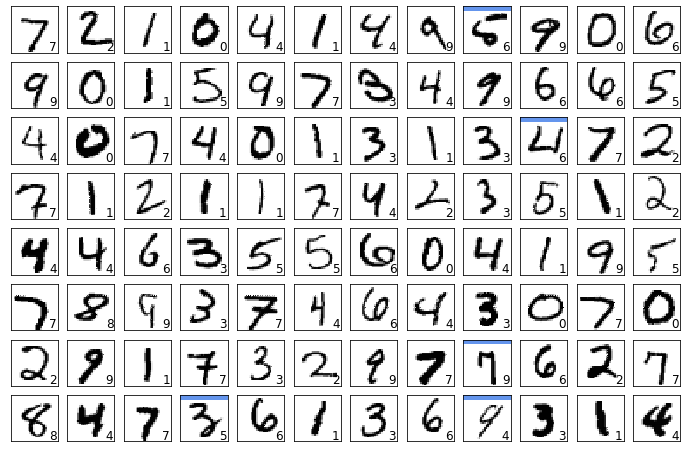

In [27]:
def show_prediction():
    n_show=96
    y=model.predict(x_test)
    plt.figure(2, figsize=(12, 8))
    plt.gray()
    
    for i in range(n_show):
        plt.subplot(8, 12, i+1)
        x = x_test[i, :]
        x = x.reshape(28, 28)
        plt.pcolor(1-x)
        wk = y[i, :]
        prediction = np.argmax(wk)
        plt.text(22, 25.5, "%d" %prediction, fontsize=12)
        if prediction != np.argmax(y_test[i, :]):
            plt.plot([0, 27], [1, 1], color='cornflowerblue', linewidth=5)
        
        plt.xlim(0, 27)
        plt.ylim(27, 0)
        plt.xticks([], "")
        plt.yticks([], "")

show_prediction()
plt.show()

sigmoid 사용시 잘못 예측된 데이터가 9개였음에 비해 relu사용시 5개로 줄었다.

## 네트워크에서 얻은 매개변수?
* 네트워크 모델의 중간층 가중치 매개 변수 `model.layers[0].get_weights()[0]`으로 얻을 수 있다.
* 바이어스 매개 변수는 `model.layers[0].get_weights()[1]`으로 얻을 수 있다.
* 출력층의 매개 변수는 `model.layers[1].get_weights()[0]`으로 얻을 수 있다.

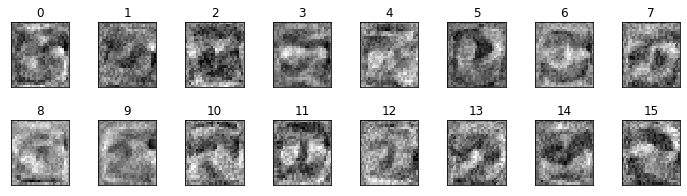

In [28]:
## 중간층 가중치 매개변수를 그림으로 나타낸다.


w = model.layers[0].get_weights()[0]
plt.figure(1, figsize=(12, 3))
plt.gray()      # 그레이스케일로 나타냄.
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(16):             # 중간층 뉴런의 수만큼 반복.
    plt.subplot(2, 8, i+1)      # 1번째부터 16번째까지 subplot 표시.
    w1 = w[:, i]                # 
    w1 = w1.reshape(28, 28)
    plt.pcolor(-w1)             # 양수는 검은색, 음수는 흰색으로 표시하기 위해 반전.
    plt.xlim(0, 27)
    plt.ylim(27, 0)
    plt.xticks([], "")
    plt.yticks([], "")
    plt.title("%d" %i)
plt.show()